## Lab 8: One-way Anova with python  

- Parametric test assumptions 
  - population distributions are normal 
  - samples have equal variances 
  - independence 
- Hypothesis 
  - $H_0=\mu_1=\mu_2=...=\mu_k$
  - $H_1$ at least one of the groups means differ 
- Test statistics: $F=\frac{MS_B}{MS_W}$
  - Reject $H_0$ if F-statitics is greater than the critical value 

In [1]:
import sys
!{sys.executable} -m pip install researchpy

In [2]:
import pandas as pd 
import researchpy as rp 


In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/researchpy/Data-sets/master/difficile.csv")
df

,person,dose,libido
0,1,1,3
1,2,1,2
2,3,1,1
3,4,1,1
4,5,1,4
5,6,2,5
6,7,2,2
7,8,2,4
8,9,2,2
9,10,2,3


In [17]:
df = pd.read_csv("https://raw.githubusercontent.com/researchpy/Data-sets/master/difficile.csv")
df.drop('person', axis= 1, inplace= True)

# Recoding value from numeric to string
df['dose'].replace({1: 'placebo', 2: 'low', 3: 'high'}, inplace= True)

df

,dose,libido
0,placebo,3
1,placebo,2
2,placebo,1
3,placebo,1
4,placebo,4
5,low,5
6,low,2
7,low,4
8,low,2
9,low,3


In [19]:
rp.summary_cont(df['libido'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,libido,15.0,3.4667,1.7674,0.4563,2.4879,4.4454


In [22]:
rp.summary_cont(df['libido'].groupby(df['dose']))

,N,Mean,SD,SE,95% Conf.,Interval
dose,,,,,,
high,5,5.0,1.5811,0.7071,3.0368,6.9632
low,5,3.2,1.3038,0.5831,1.5811,4.8189
placebo,5,2.2,1.3038,0.5831,0.5811,3.8189


1. Anova analysis 

- One way anova using scipy.stats 
  - only returns the F-statistics and p-value 

In [24]:
# one way anova using scipy.stats 
import scipy.stats as stats
stats.f_oneway(df['libido'][df['dose'] == 'high'],
               df['libido'][df['dose'] == 'low'],
               df['libido'][df['dose'] == 'placebo'])
# There is a statistically significant difference between the groups and their effects the libido, F= 5.12, p-value= 0.0247.

F_onewayResult(statistic=5.11864406779661, pvalue=0.024694289538222603)

- One way anova using statsmodel 
  - implementation through two steps:
    - fit the model using an estimation method: the defaurt one is the OLS
      - **ols("outcome_variable ~ independent_variable", data= data_frame).fit()**<br>
      - In the case of an ANOVA, the independent variable will be categorical. The pseudo code above would work if you were conducting a simple linear regression, but that's not what we are here for! Have to modify the pseudo code which would make it look like:
        - **ols("outcome_variable ~ C(independent_variable)", data= data_frame).fit()**
    -  pass fitted model into ANOVA to produce table 

In [25]:
# one way anov using statsmodel 
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
import statsmodels.stats.anova as anova 
model = ols('libido ~ C(dose)',data=df).fit()
table = sm.stats.anova_lm(model,typ=2)
table

,sum_sq,df,F,PR(>F)
C(dose),20.133333,2.0,5.118644,0.024694
Residual,23.600000,12.0,NaN,NaN


In [26]:
table=anova.anova_lm(model)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(dose),2.0,20.133333,10.066667,5.118644,0.024694
Residual,12.0,23.600000,1.966667,NaN,NaN


- However, the above table provides all information one needs in order to interpret if the results are significant, it does not provide any effect size measures to tell if the statistical signicance is meaningful. 
- The function below calculates eta squared $\eta^2$ ( the same thing as $R^2$ and omega-squred $\omega^2$ (been considered as a better measure of effect size since it is unbaised in it's calculation by accounting for the degrees of freedom in the model)


In [29]:
"""
The function below was created specifically for the one-way ANOVA table results returned for Type II sum of squares
"""
def anova_table(aov):
      aov['mean_sq']=aov[:]['sum_sq']/aov[:]['df']
      aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
      aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
      cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
      aov = aov[cols]
      return aov
anova_table(table)
# There is a statistically significant difference between the groups and their effects the libido, F= 5.12, p-value= 0.0247, with an overall large effect, $\omega^2= 0.35.



,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(dose),20.133333,2.0,10.066667,5.118644,0.024694,0.460366,0.354486
Residual,23.600000,12.0,1.966667,NaN,NaN,NaN,NaN


----
2. Assumption Check


- Independence: What this means is that all groups are mutually exclusive, i.e. an individual can only belong in one group. Also, this means that the data is not repeated measures (not collected through time). In this example, this condition is met.

- Normality: The assumption of normality is tested on the residuals of the model when coming from an ANOVA or regression framework. 
  - One method for testing the assumption of normality is the Shapiro-Wilk test . This can be completed using the shapiro() method from scipy.stats.
  - One method of visually checking the distribution is to use a probability plot with or without the correlation value $R^2$ to assess the observed values correlation with the theoretical distribution in question - in the current case it would be the Gaussian (a.k.a the normal) distribution.

In [30]:

import scipy.stats as stats
stats.shapiro(model.resid)
# The test is non-significant, W= 0.9167, p= 0.1715, which indicates that the residuals are normally distributed.

ShapiroResult(statistic=0.9166916012763977, pvalue=0.1714693009853363)

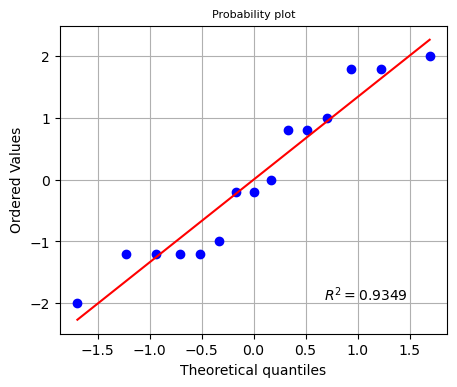

In [32]:
import matplotlib.pyplot as plt 
fig = plt.figure(figsize = (5,4))
ax = fig.add_subplot(111)
normality_plot,stat = stats.probplot(model.resid, plot = plt, rvalue = True)
ax.set_title('Probability plot', fontsize=8)
ax.grid()
ax.set
plt.show()

- Homogeneity of variance 
  - One method for testing this assumption is the Levene's test of homogeneity of variances. This can be completed using the levene() method from Scipy.stats.
  - Another method is the visual test 

In [33]:
stats.levene(df['libido'][df['dose'] == 'high'],
             df['libido'][df['dose'] == 'low'],
             df['libido'][df['dose'] == 'placebo'])
# The Levene's test of homogeneity of variances is not significant which indicates that the groups have non-statistically significant difference in their varability.

LeveneResult(statistic=0.11764705882352934, pvalue=0.8900225182757423)

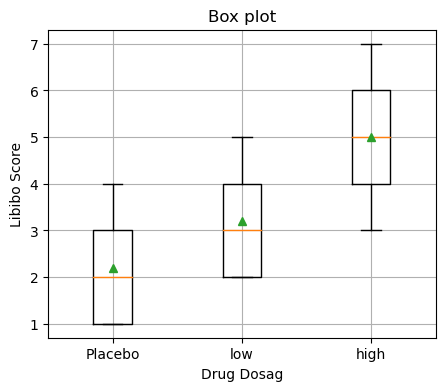

In [34]:
fig = plt.figure(figsize = (5,4))
ax = fig.add_subplot(111)
ax.set_title('Box plot')
ax.grid()
ax.set
data = [df['libido'][df['dose'] == 'placebo'],
        df['libido'][df['dose'] == 'low'],
        df['libido'][df['dose'] == 'high']]
ax.boxplot(data, labels = ['Placebo','low','high'],showmeans = True)
plt.xlabel('Drug Dosag')
plt.ylabel('Libibo Score')
plt.show()